In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import pickle as pk
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

---

## Load DrugBank

In [3]:
def morgan_fingerprint(mol,radius=2,nbits=2048):
    return torch.from_numpy(np.array(AllChem.GetMorganFingerprintAsBitVect(mol,radius,nbits)))

In [4]:
molecules = Chem.SDMolSupplier('/afs/csail.mit.edu/u/s/samsl/Work/databases/DrugBank/all_structures.sdf')
moleculeDict = {m.GetProp('DRUGBANK_ID'): m for m in molecules if m is not None}

[10:50:16] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[10:50:16] ERROR: Could not sanitize molecule ending on line 289199
[10:50:16] ERROR: Explicit valence for atom # 13 Cl, 5, is greater than permitted
[10:50:16] Explicit valence for atom # 19 O, 3, is greater than permitted
[10:50:16] ERROR: Could not sanitize molecule ending on line 399275
[10:50:16] ERROR: Explicit valence for atom # 19 O, 3, is greater than permitted
[10:50:17] Explicit valence for atom # 1 N, 4, is greater than permitted
[10:50:17] ERROR: Could not sanitize molecule ending on line 522730
[10:50:17] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[10:50:17] Explicit valence for atom # 1 N, 4, is greater than permitted
[10:50:17] ERROR: Could not sanitize molecule ending on line 578040
[10:50:17] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
[10:50:17] Explicit valence for atom # 12 N, 4, is greater than permitted
[10:50:17] ERROR: Could not sanitize

In [5]:
import xml.etree.ElementTree as ET
full_drugbank = ET.parse('/afs/csail.mit.edu/u/s/samsl/Work/databases/DrugBank/full_database.xml')
drugbank_root = full_drugbank.getroot()
namespaces = {'drugbank': 'http://www.drugbank.ca'}

In [6]:
class ATC_Code:
    def __init__(self, xmlcode):
        self.code = c.attrib["code"]
        self.lvls = xmlcode.findall("drugbank:level",namespaces)
        self.lvl4 = (self.lvls[0].attrib["code"], self.lvls[0].text)
        self.lvl3 = (self.lvls[1].attrib["code"], self.lvls[1].text)
        self.lvl2 = (self.lvls[2].attrib["code"], self.lvls[2].text)
        self.lvl1 = (self.lvls[3].attrib["code"], self.lvls[3].text)
        
    def __repr__(self):
        return f"{self.code} ({self.lvl1[1]}, {self.lvl2[1]}, {self.lvl3[1]}, {self.lvl4[1]})"
    
    def __eq__(self, other):
        return self.code == other.code
    
class Drug:
    def __init__(self, dbid, smiles, codes):
        self.name = dbid
        self.smiles = smiles
        self.codes = codes
        
        self.embeddings = {}

    def __repr__(self):
        return f"{self.name}: {[i for i in self.codes]}"
        
    def __eq__(self, other):
        return self.name == other.name

    def setRDKitMol(self,m):
        self.rdkitmol = m
        
    def getRDKitMol(self):
        return self.rdkitmol
        
    def setEmbedding(self,embName,embedding):
        self.embeddings[embName] = embedding
        
    def getEmbedding(self,embName):
        return self.embeddings[embName]

In [7]:
drugDict = {}

for drxml in tqdm(drugbank_root, total=len(drugbank_root)):
    dbid = drxml.find('drugbank:drugbank-id[@primary="true"]',namespaces).text
    if dbid in moleculeDict.keys():
        codesxml = drxml.findall('drugbank:atc-codes/drugbank:atc-code', namespaces)
        codesclass = []
        for c in codesxml:
            codesclass.append(ATC_Code(c))
        drclass = Drug(dbid, moleculeDict[dbid].GetProp('SMILES'), codesclass)
        drugDict[dbid] = drclass
    else:
        continue

  0%|          | 0/14594 [00:00<?, ?it/s]

In [8]:
print(len(drugDict),'drugs from DrugBank')

11290 drugs from DrugBank


In [9]:
drugDict['DB00006']

DB00006: [B01AE06 (BLOOD AND BLOOD FORMING ORGANS, ANTITHROMBOTIC AGENTS, ANTITHROMBOTIC AGENTS, Direct thrombin inhibitors)]

In [10]:
topLvlClasses = {}

for k,v in drugDict.items():
    if len(v.codes):
        topLvlClasses[k] = v.codes[0].lvl1[0]
    else:
        topLvlClasses[k] = '-'

In [11]:
from collections import Counter
cntr = Counter(topLvlClasses.values())
cntr

Counter({'B': 94,
         'L': 231,
         'R': 201,
         'H': 42,
         '-': 8447,
         'J': 305,
         'A': 329,
         'V': 152,
         'G': 163,
         'D': 174,
         'N': 478,
         'S': 98,
         'M': 138,
         'C': 345,
         'P': 93})

---

## Load Surfaceome

In [12]:
tdb = pd.read_excel('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/table_S3_surfaceome.xlsx')
tdb.columns = tdb.iloc[0]

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [13]:
surface_db = tdb[tdb['Surfaceome Label'] == 'surface']

In [14]:
surface_db.columns

Index(['UniProt name', 'UniProt accession', 'UniProt description',
       'UniProt gene', 'Surfaceome Label', 'Surfaceome Label Source',
       'Comment', 'length', 'TM domains', 'signalpeptide', 'topology',
       'topology source', 'MachineLearning trainingset',
       'MachineLearning score',
       'MachineLearning FPR class (1=1%, 2=5%, 3=15%)', 'Ensembl gene',
       'Ensembl protein', 'CD number', 'Membranome Almen main-class',
       'Membranome Almen sub-class', 'nxst motifs', 'noncyt. nxst count',
       'peps with accessible noncyt. nxst', 'noncyt. Trp count',
       'peps with accessible noncyt. Trp', 'noncyt. Tyr count',
       'peps with accessible noncyt. Tyr', 'glycomineN sites',
       'glycomineO sites', 'glycomineC sites', 'CSPA category',
       'CSPA peptide count', 'CSPA peptides', 'CSPA N115 sites', 'CSPA id',
       'UniProt subcellular', 'UniProt keywords', 'UniProt uniref',
       'COMPARTMENTS link', 'COMPARTMENTS benchmark pos',
       'COMPARTMENTS benchmar

In [15]:
surface_db[['UniProt accession', 'Ensembl gene','length','TM domains','Membranome Almen main-class','UniProt subcellular']]

,UniProt accession,Ensembl gene,length,TM domains,Membranome Almen main-class,UniProt subcellular
2217,A0AV02,ENSG00000221955,714,13,Transporters,Membrane (Multi-pass membrane protein)
2218,A0FGR9,ENSG00000158220,886,2,Unclassified,Cell membrane (Peripheral membrane protein);En...
2219,A0PJK1,ENSG00000154025,596,14,Transporters,Cell membrane (Multi-pass membrane protein)
2220,A0PK11,ENSG00000249581,232,4,Unclassified,Membrane (Multi-pass membrane protein)
2221,A0ZSE6,ENSG00000235156,113,1,Miscellaneous,Membrane (Single-pass membrane protein)
...,...,...,...,...,...,...
5098,Q9Y6N8,ENSG00000040731,788,1,Miscellaneous,Cell membrane (Single-pass type I membrane pro...
5099,Q9Y6Q6,ENSG00000141655,616,1,Receptors,Cell membrane (Single-pass type I membrane pro...
5100,Q9Y6R1,ENSG00000080493,1079,10,Transporters,Basolateral cell membrane (Multi- pass membran...
5101,Q9Y6W8,ENSG00000163600,199,1,Unclassified,Cell membrane (Single-pass type I membrane pro...


In [16]:
### Write list of sequences

with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surface_uniprot_list.txt','w+') as f:
    for p in surface_db['UniProt accession'].to_list():
        f.write(f"{p}\n")
        
### Download these sequences from UniProt

In [17]:
updb = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_download.tsv',sep='\t')
updb = updb[~updb['Sequence'].isna()]

In [18]:
updb.head()

,Entry,Protein names,Gene names,Organism,Length,Sequence,EC number,Cross-reference (Pfam),Cross-reference (BindingDB),Cross-reference (DrugBank)
0,A0AV02,Solute carrier family 12 member 8 (Cation-chlo...,SLC12A8 CCC9,Homo sapiens (Human),714.0,MTQMSQVQELFHEAAQQDALAQPQPWWKTQLFMWEPVLFGTWDGVF...,NaN,PF00324;,NaN,NaN
1,A0FGR9,Extended synaptotagmin-3 (E-Syt3) (Chr3Syt),ESYT3 FAM62C,Homo sapiens (Human),886.0,MRAEEPCAPGAPSALGAQRTPGPELRLSSQLLPELCTFVVRVLFYL...,NaN,PF00168;PF17047;,NaN,NaN
2,A0PJK1,Sodium/glucose cotransporter 5 (Na(+)/glucose ...,SLC5A10 SGLT5,Homo sapiens (Human),596.0,MAANSTSDLHTPGTQLSVADIIVITVYFALNVAVGIWSSCRASRNT...,NaN,PF00474;,NaN,NaN
3,A0PK11,Clarin-2,CLRN2,Homo sapiens (Human),232.0,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,NaN,NaN,NaN,NaN
4,A0ZSE6,Cell cycle control protein 50C (Transmembrane ...,TMEM30CP CDC50C TMEM30C,Homo sapiens (Human),113.0,MEERAQHCLSRLLDNSALKQQELPIHRLYFTARRVLFVFFATGIFC...,NaN,NaN,NaN,NaN


In [19]:
mrgdb = pd.merge(surface_db, updb, left_on='UniProt accession', right_on='Entry',how='inner')

In [20]:
with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_seqs.fasta','w+') as f:
    for i,r in mrgdb.iterrows():
        f.write(f">{r.Entry}\n{r.Sequence}\n")

### Domain Annotation

In [21]:
#!/scratch1/rsingh/tools/bin/hmmscan -o /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.out --tblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.tblout --domtblout /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.domtblout --acc --noali --notextw --cut_ga /afs/csail.mit.edu/u/r/rsingh/work/corals/data/raw/pfam/Pfam-A.hmm /afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_uniprot_seqs.fasta 

In [22]:
from Bio.SearchIO.HmmerIO.hmmer3_tab import Hmmer3TabParser

In [23]:
with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/surfaceome/surfaceome_pfam_scan.tblout','r') as f:
    hmmerhits = list(Hmmer3TabParser(f))

In [24]:
domtbl = []

for rec in hmmerhits:
    for hit in rec.hits:
        domtbl.append((rec.id, hit.id, hit.accession, hit.evalue, hit.bitscore))
        
domtbl = pd.DataFrame(domtbl,columns=['Query','DomName','DomAccession','eval','bitscore'])

In [25]:
grpdomtbl = domtbl.groupby('Query')['DomName','DomAccession'].transform(lambda x: ','.join(x))
grpdomtbl.index = domtbl.Query
grpdomtbl = grpdomtbl.reset_index().drop_duplicates()

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [162]:
full_dom_db.loc['O14524']

UniProt name                                                                           T194A_HUMAN
UniProt description                                                     Transmembrane protein 194A
UniProt gene                                                                              TMEM194A
Surfaceome Label                                                                           surface
Surfaceome Label Source                                                           machine learning
Comment                                                                                        NaN
length                                                                                         444
TM domains                                                                                       6
signalpeptide                                                                                    0
topology                                         CY:1-20;TM:21-43;NC:44-162;TM:163-180;CY:181-1...
topology s

In [26]:
full_dom_db = pd.merge(mrgdb,grpdomtbl,left_on='Entry', right_on='Query', how='inner')
full_dom_db = full_dom_db.set_index('UniProt accession')
full_dom_db.head()

,UniProt name,UniProt description,UniProt gene,Surfaceome Label,Surfaceome Label Source,Comment,length,TM domains,signalpeptide,topology,...,Organism,Length,Sequence,EC number,Cross-reference (Pfam),Cross-reference (BindingDB),Cross-reference (DrugBank),Query,DomName,DomAccession
UniProt accession,,,,,,,,,,,,,,,,,,,,,
A0AV02,S12A8_HUMAN,Solute carrier family 12 member 8,SLC12A8,surface,machine learning,NaN,714,13,0,NC:1-37;TM:38-60;CY:61-71;TM:72-93;NC:94-98;TM...,...,Homo sapiens (Human),714.0,MTQMSQVQELFHEAAQQDALAQPQPWWKTQLFMWEPVLFGTWDGVF...,NaN,PF00324;,NaN,NaN,A0AV02,AA_permease,PF00324.22
A0FGR9,ESYT3_HUMAN,Extended synaptotagmin-3,ESYT3,surface,pos. trainingset,NaN,886,2,0,CY:1-27;TM:28-46;NC:47-51;TM:52-72;CY:73-886,...,Homo sapiens (Human),886.0,MRAEEPCAPGAPSALGAQRTPGPELRLSSQLLPELCTFVVRVLFYL...,NaN,PF00168;PF17047;,NaN,NaN,A0FGR9,"SMP_LBD,C2","PF17047.6,PF00168.31"
A0PJK1,SC5AA_HUMAN,Sodium/glucose cotransporter 5,SLC5A10,surface,machine learning,NaN,596,14,0,NC:1-15;TM:16-37;CY:38-73;TM:74-93;NC:94-98;TM...,...,Homo sapiens (Human),596.0,MAANSTSDLHTPGTQLSVADIIVITVYFALNVAVGIWSSCRASRNT...,NaN,PF00474;,NaN,NaN,A0PJK1,SSF,PF00474.18
A1A5B4,ANO9_HUMAN,Anoctamin-9,ANO9,surface,pos. trainingset,NaN,782,8,0,CY:1-195;TM:196-217;NC:218-266;TM:267-285;CY:2...,...,Homo sapiens (Human),782.0,MQGEESLRILVEPEGDSFPLMEISTCETEASEQWDYVLVAQRHTQR...,NaN,PF04547;,NaN,NaN,A1A5B4,"Anoctamin,Anoct_dimer","PF04547.13,PF16178.6"
A1A5C7,S22AN_HUMAN,Solute carrier family 22 member 23,SLC22A23,surface,machine learning,NaN,686,10,0,NC:1-230;TM:231-253;CY:254-258;TM:259-280;NC:2...,...,Homo sapiens (Human),686.0,MAIDRRREAAGGGPGRQPAPAEENGSLPPGDAAASAPLGGRAGPGG...,NaN,PF00083;,NaN,NaN,A1A5C7,"Sugar_tr,MFS_1","PF00083.25,PF07690.17"


## How well documented is this target?

In [163]:
import requests, json

In [166]:
def get_tdl_novelty(pid):
    url = 'https://pharos-api.ncats.io/graphql'
    query = {'query': 'query targetDetails{target(q:{sym:"' + pid + '"}) {name tdl fam sym description novelty}}'}
    r = requests.post(url, json=query)
    assert r.status_code==200
    json_d = json.loads(r.text)
    tdl = json_d['data']['target']['tdl']
    nov = json_d['data']['target']['novelty']
    return tdl, nov
    

In [ ]:
novelty_db = {}
for x in tqdm(full_dom_db.index,total=len(full_dom_db)):
    novelty_db[x] = get_tdl_novelty(x)

  0%|          | 0/2716 [00:00<?, ?it/s]

In [168]:
get_tdl_novelty('A1A5C7')

('Tbio', 0.23405744)

---

# Project into common space

In [27]:
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding

In [28]:
# Load model
device = torch.device(6)
mol_f = MorganFeaturizer().cuda(device)
prot_f = ProtBertFeaturizer().cuda(device)
model = SimpleCoembedding(mol_f.shape, prot_f.shape, 1024)
model.load_state_dict(torch.load("../best_models/ProdModels/prod_within_state.pt"))
# model = torch.load("../best_models/BindingDB_ProtBert_Morgan_progressiveMargin_DUDeWithin_best_model.sav").to(torch.device(6))

<All keys matched successfully>

In [29]:
model = model.to(device)

In [30]:
prot_names = []
prot_domains = []
prot_projections = []
mol_names = []
mol_projections = []

with torch.set_grad_enabled(False):
    for _, r in tqdm(full_dom_db.iterrows(),total=len(full_dom_db)):
        seq = r.Sequence
        seqName = r.Query
        # prot_emb = prot_f(seq).unsqueeze(0)
        # prot_proj = model.target_projector(prot_emb).squeeze().detach().cpu().numpy()
        # prot_proj = model.prot_projector(prot_emb).squeeze().detach().cpu().numpy()
        prot_names.append(seqName)
        prot_domains.append(r.DomAccession)
        # prot_projections.append(prot_proj)

    for molName, mol in tqdm(moleculeDict.items(),total=len(moleculeDict)):
        # mol_emb = mol_f(Chem.MolToSmiles(mol)).unsqueeze(0)
        # mol_proj = model2.drug_projector(mol_emb).squeeze().detach().cpu().numpy()
        # mol_proj = model.mol_projector(mol_emb).squeeze().detach().cpu().numpy()
        mol_names.append(molName)
        # mol_projections.append(mol_proj)

  0%|          | 0/2716 [00:00<?, ?it/s]

  0%|          | 0/11290 [00:00<?, ?it/s]

In [31]:
protbert_embs = {}

for _,r in tqdm(full_dom_db.iterrows(),total=len(full_dom_db)):
    protbert_embs[r.Query] = prot_f(r.Sequence).detach().cpu().numpy()
    
protbert_np = np.stack(protbert_embs.values())

  0%|          | 0/2716 [00:00<?, ?it/s]

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [32]:
# all_embeddings = np.concatenate([mol_projections,prot_projections],axis=0)
# pk.dump(all_embeddings,open(f'{DATA_DIR}/protbert_morgan_drugbank_x_surfaceome_embeddings_20220905.pk','wb'))

all_embeddings = pk.load(open(f'{DATA_DIR}/protbert_morgan_drugbank_x_surfaceome_embeddings.pk','rb')).squeeze()
# all_embeddings = pk.load(open(f'{DATA_DIR}/protbert_morgan_drugbank_x_surfaceome_embeddings_20220707.pk','rb')).squeeze()
mol_projections = all_embeddings[:len(moleculeDict)]
prot_projections = all_embeddings[-len(full_dom_db):]

In [ ]:
# pp_dict = {i: j for (i,j) in zip(full_dom_db.index, prot_projections)}
# mp_dict = {i: j for (i,j) in zip(moleculeDict.keys(), mol_projections)}

In [ ]:
# pk.dump(mp_dict,open(f'{DATA_DIR}/pb_morgan_drugbank_embeddings_202209205.pk','wb'))
# pk.dump(pp_dict,open(f'{DATA_DIR}/pb_morgan_surfaceome_embeddings_20220905.pk','wb'))
# mp_dict = pk.load(open(f'{DATA_DIR}/pb_morgan_drugbank_embeddings_20220829.pk','rb'))
# pp_dict = pk.load(open(f'{DATA_DIR}/pb_morgan_surfaceome_embeddings_20220829.pk','rb'))

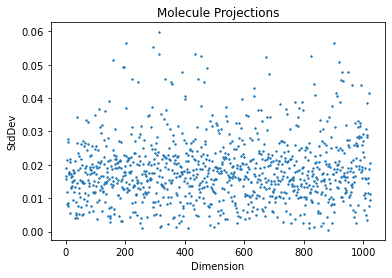

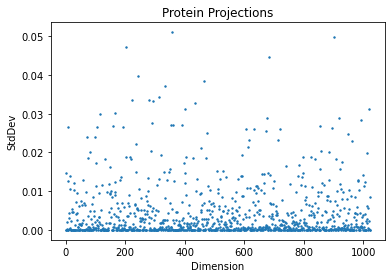

In [33]:
plt.scatter(np.arange(1024), mol_projections.squeeze().std(axis=0),s=2)
plt.title('Molecule Projections')
plt.xlabel('Dimension')
plt.ylabel('StdDev')
plt.show()

plt.scatter(np.arange(1024), prot_projections.squeeze().std(axis=0),s=2)
plt.title('Protein Projections')
plt.xlabel('Dimension')
plt.ylabel('StdDev')
plt.show()

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [35]:
mol_projections = np.stack(mol_projections).squeeze()
prot_projections = np.stack(prot_projections).squeeze()
all_embeddings = np.concatenate([prot_projections, mol_projections])

In [36]:
# embed_kpca = KernelPCA(kernel="cosine").fit_transform(all_embeddings)
embed_tsne = TSNE(metric="cosine",random_state=61998).fit_transform(all_embeddings)
protbert_tsne = TSNE(metric="cosine").fit_transform(protbert_np)

/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/

In [ ]:
# embed_umap = UMAP(metric="cosine").fit_transform(all_embeddings)

---

# Visualize space by categories

In [37]:
domsrted = domtbl.groupby('DomAccession').Query.count().sort_values(ascending=False)

In [38]:
domsrted

DomAccession
PF00001.22    699
PF13853.7     445
PF00047.26    265
PF13927.7     247
PF10320.10    239
             ... 
PF12104.9       1
PF03547.19      1
PF03583.15      1
PF11587.9       1
PF10160.10      1
Name: Query, Length: 780, dtype: int64

In [39]:
cntr

Counter({'B': 94,
         'L': 231,
         'R': 201,
         'H': 42,
         '-': 8447,
         'J': 305,
         'A': 329,
         'V': 152,
         'G': 163,
         'D': 174,
         'N': 478,
         'S': 98,
         'M': 138,
         'C': 345,
         'P': 93})

In [40]:
def get_pfd_code(code):
    is_pfd = ['yes' if code in full_dom_db.loc[i,'DomAccession'] else 'no' for i in prot_names]
    # is_pfd = is_pfd + ['mol']*mol_projections.shape[0]
    # print(sum([1 if i=='yes' else 0 for i in is_pfd]))
    return is_pfd

def get_atc_code(code):
    is_atc = ['yes' if topLvlClasses[i] == code else 'no' for i in mol_names]
    print(sum([1 if i=='yes' else 0 for i in is_atc]))
    return is_atc

In [41]:
almen_class = [mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen main-class'] for i in prot_names]
almen_minor = [mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen sub-class'] for i in prot_names]

In [42]:
# almen_class = {i: mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen main-class'] for i in prot_names}
# pk.dump(almen_class,open(f'../nbdata/surfaceome_almen_major.pk','wb'))
# almen_minor = {i: mrgdb.set_index('UniProt accession').loc[i, 'Membranome Almen sub-class'] for i in prot_names}
# pk.dump(almen_minor,open(f'../nbdata/surfaceome_almen_minor.pk','wb'))

In [43]:
atc_code = [topLvlClasses[i] for i in mol_names]

In [44]:
n_prots = prot_projections.shape[0]
n_drugs = mol_projections.shape[0]

In [45]:
from sklearn.metrics import silhouette_score

In [46]:
oursil = silhouette_score(prot_projections, almen_class, metric='cosine')
# pbsil = silhouette_score(protbert_np, almen_class, metric='cosine')
print(oursil)#, pbsil)

0.01801699


In [64]:
tab10_blue = sns.color_palette('tab10')[0]
tab10_red = sns.color_palette('tab10')[3]
tab10_green = sns.color_palette('tab10')[2]
tab10_grey = sns.color_palette('tab10')[7]
light_grey = (0.8,0.8,0.8)
palette = {"Transporters": tab10_blue, "Unclassified": light_grey, "Miscellaneous": tab10_grey, "Receptors": tab10_red, "Enzymes": tab10_green}

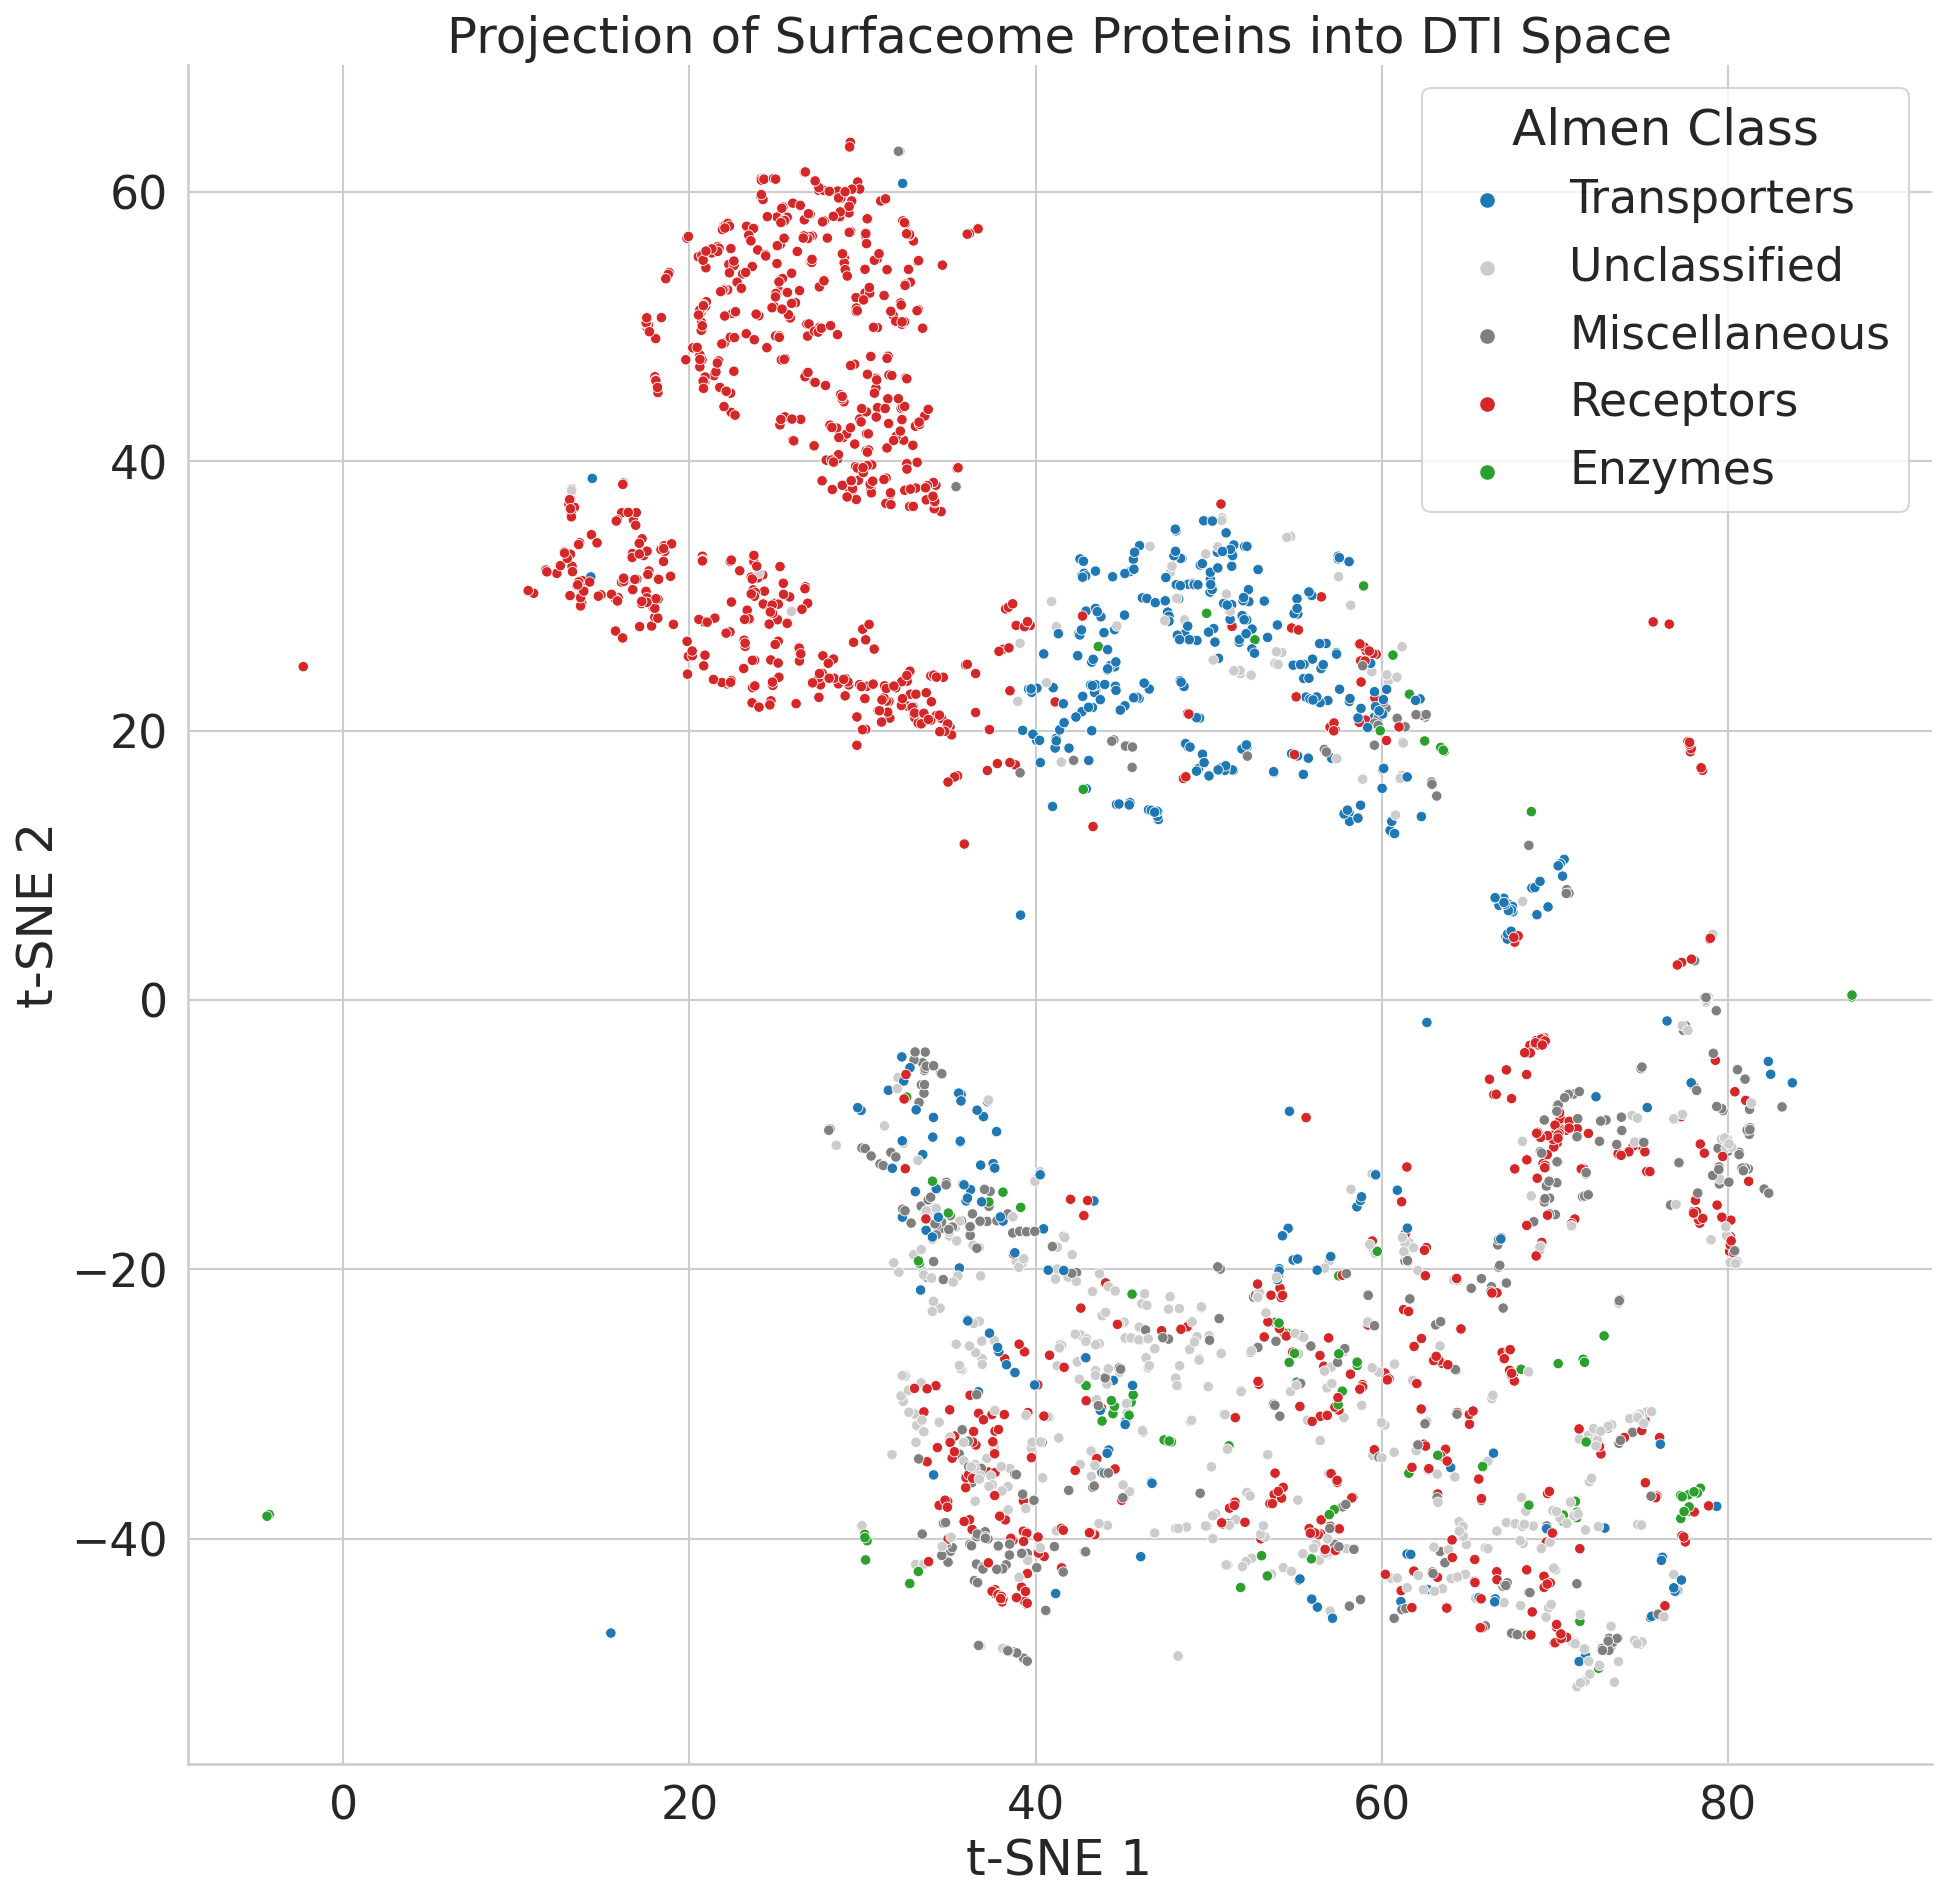

In [94]:
sns.set(style='whitegrid',font_scale=2)
plt.figure(figsize=(15, 15), dpi=150)

style = ['Protein'] * prot_projections.shape[0]# + ['Molecule'] * mol_projections.shape[0]
# style = ['Molecule'] * mol_projections.shape[0]

surfaceome_df = pd.DataFrame({
    't-SNE 1': embed_tsne[:n_prots,0],
    't-SNE 2': embed_tsne[:n_prots,1],
    'Almen Class': almen_class
})

sns.scatterplot(
    data = surfaceome_df,
    x = "t-SNE 1",
    y = "t-SNE 2",
    hue = 'Almen Class',
    s=25,
    alpha=1,
    palette=palette,
   )
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Projection of Surfaceome Proteins into DTI Space')
sns.despine()
plt.savefig('../img/surfaceome_almen_class_tsne.svg',bbox_inches='tight')
plt.show()

In [69]:
# sns.set(style='whitegrid',font_scale=1.5)
# plt.figure(figsize=(15, 15), dpi=150)

# style = ['Protein'] * prot_projections.shape[0]# + ['Molecule'] * mol_projections.shape[0]
# # style = ['Molecule'] * mol_projections.shape[0]

# surfaceome_df = pd.DataFrame({
#     't-SNE 1': protbert_tsne[:n_prots,0],
#     't-SNE 2': protbert_tsne[:n_prots,1],
#     'Almen Class': almen_class
# })

# sns.scatterplot(
#     data = surfaceome_df,
#     x = "t-SNE 1",
#     y = "t-SNE 2",
#     hue = 'Almen Class',
#     s=25,
#     alpha=1,
#     palette=palette,
#    )
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.title('ProtBert Embeddings')
# sns.despine()
# # plt.savefig('../img/surfaceome_almen_class_tsne.png',bbox_inches='tight')
# plt.show()

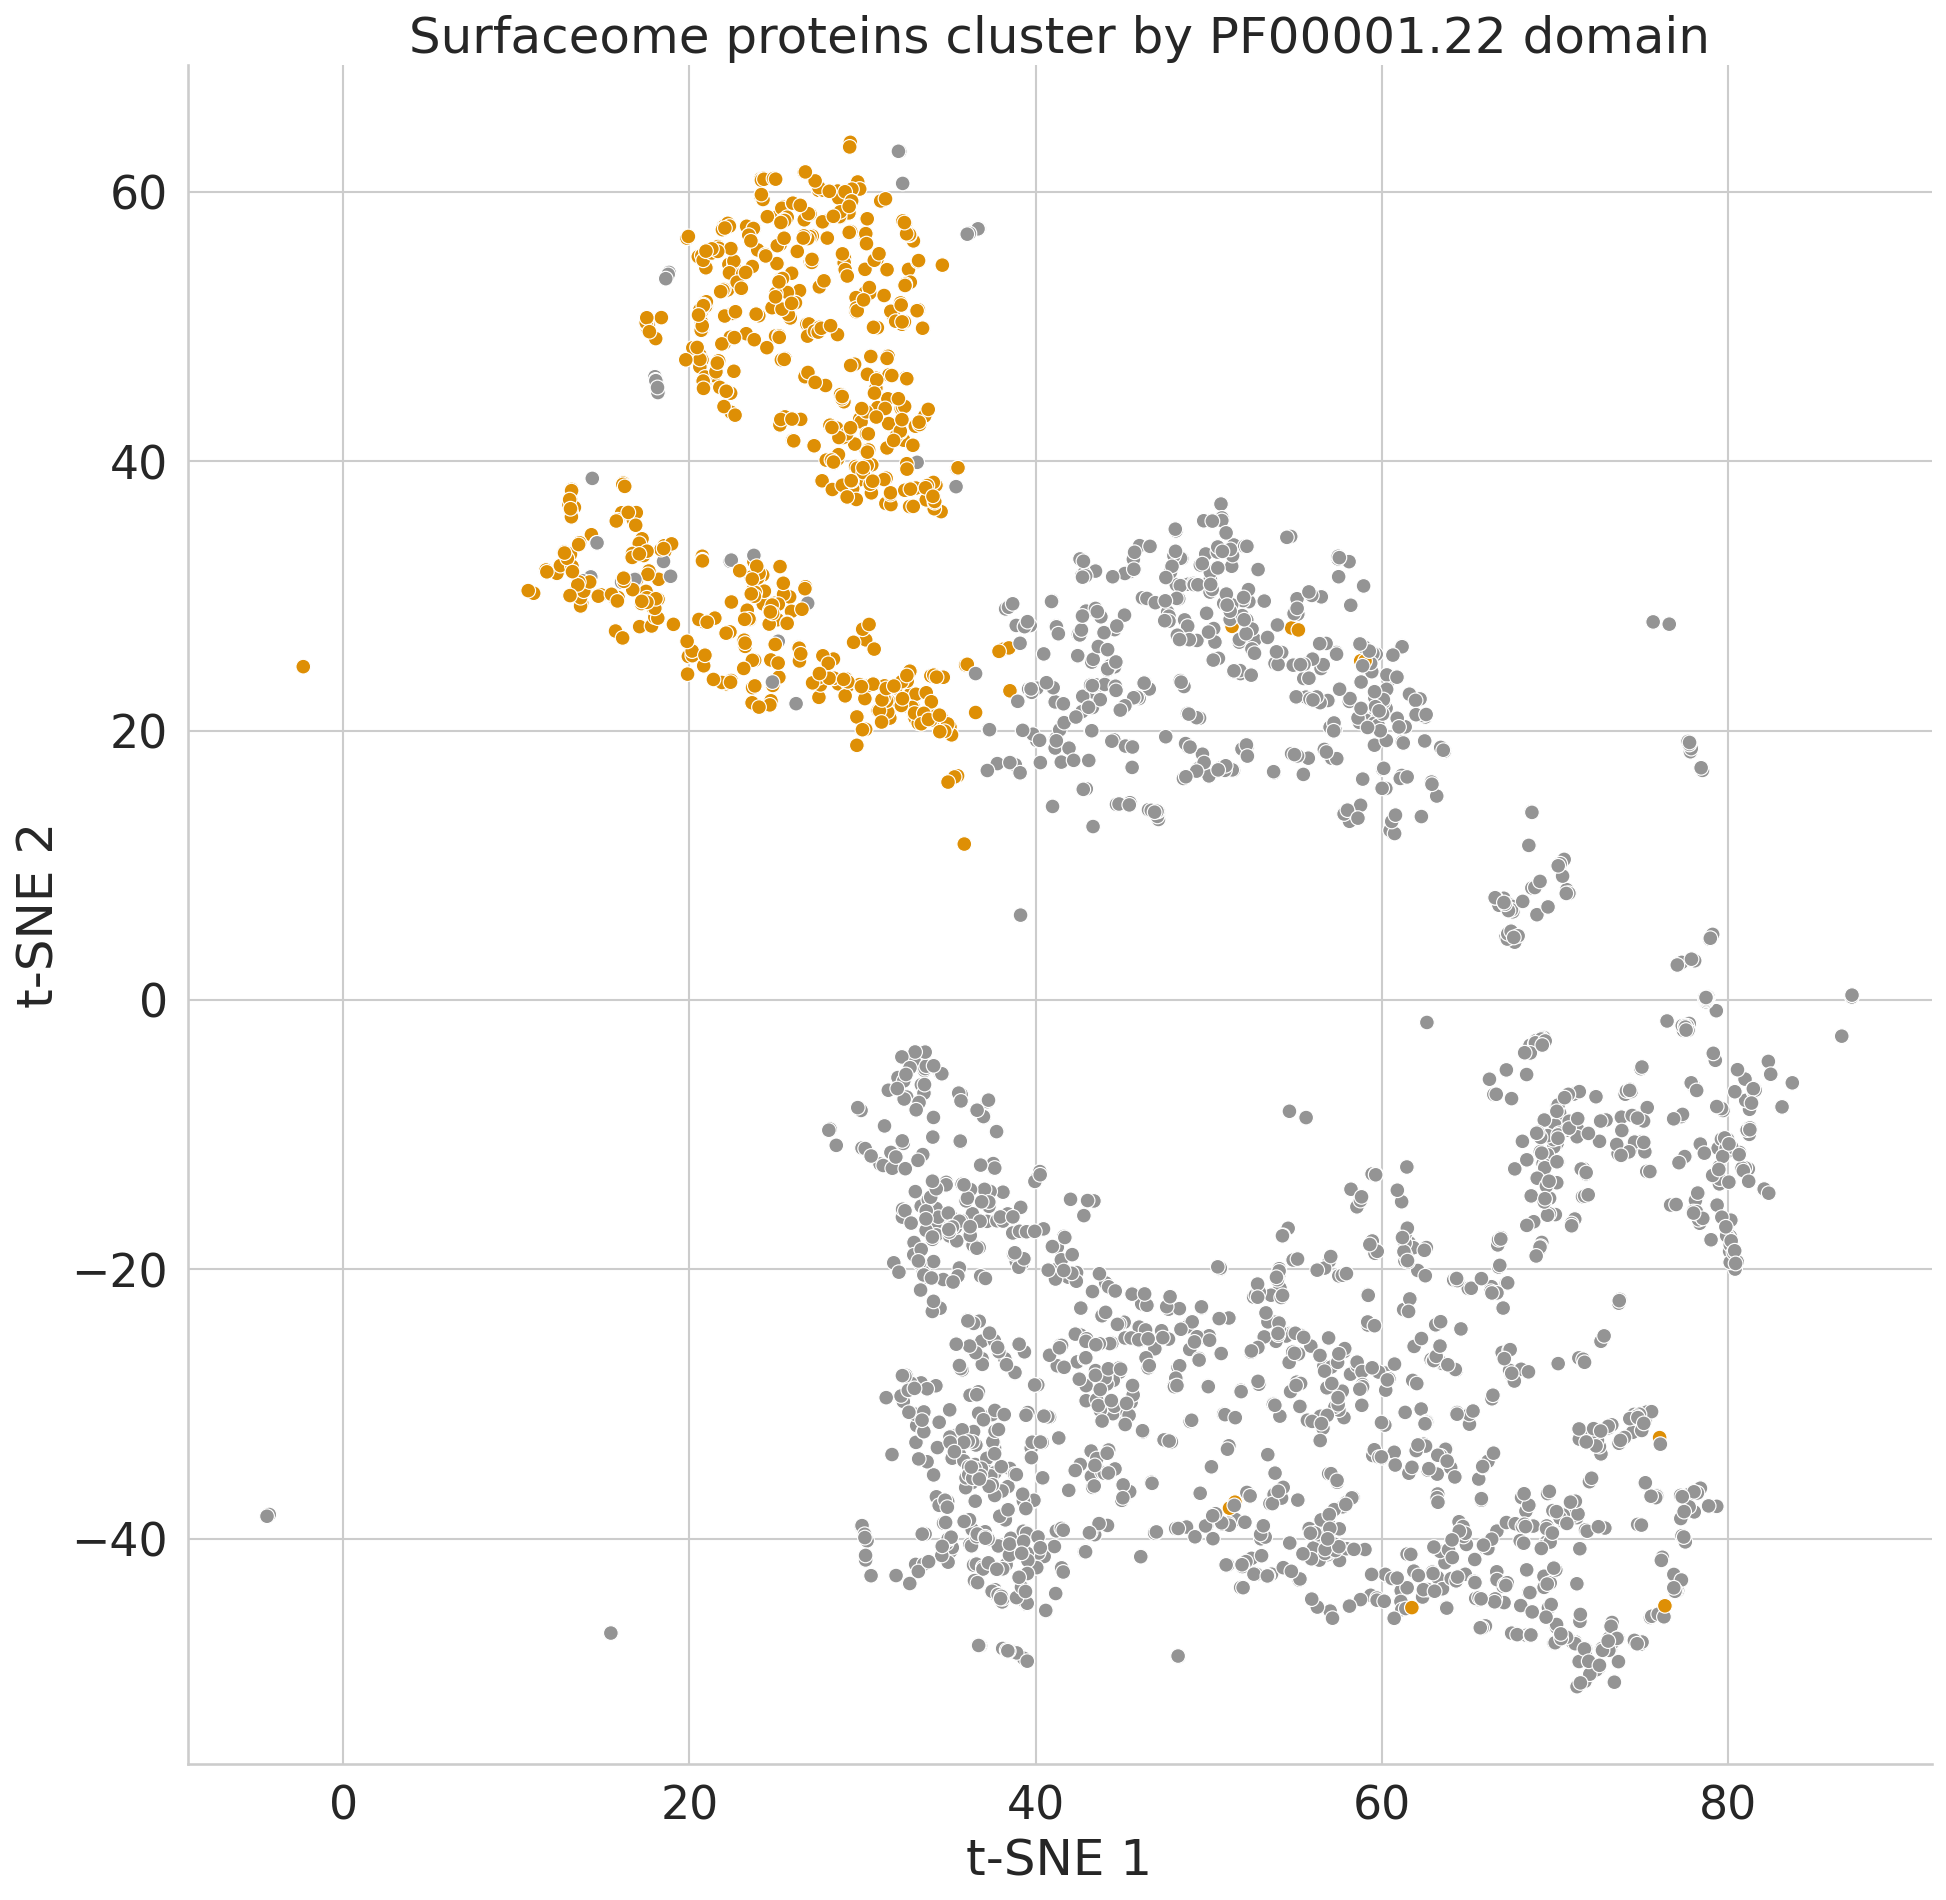

In [72]:
sns.set(style='whitegrid',font_scale=2)
plt.figure(figsize=(15, 15), dpi=150)

pal = [sns.color_palette("colorblind")[i] for i in [7,1]]

ind = 0
domain = domsrted.index[ind]

plot_dom_df = pd.DataFrame({
    't-SNE 1': embed_tsne[:prot_projections.shape[0],0],
    't-SNE 2': embed_tsne[:prot_projections.shape[0],1],
    f'Has {domain} Domain?': get_pfd_code(domain)
})

ax = sns.scatterplot(
    data = plot_dom_df,
    x = 't-SNE 1',
    y = 't-SNE 2',
    hue = f'Has {domain} Domain?',
    s=50,
    alpha=1,
    palette = pal,
)
ax.get_legend().set_visible(False)
plt.title(f'Surfaceome proteins cluster by {domsrted.index[0]} domain')
sns.despine()
plt.savefig(f'../img/surfaceome_pfam{domain}_scatter.svg',bbox_inches='tight')
plt.show()

In [73]:
do_plot_each = False

silscores = []
# tsnescores = []
# randscores = []
protscores = []

pal = [sns.color_palette("colorblind")[i] for i in [7,1]]
for domn in tqdm(domsrted.index[:50]):
    silscore = silhouette_score(prot_projections, get_pfd_code(domn), metric='cosine')
    # siltsne = silhouette_score(embed_tsne[:prot_projections.shape[0]], get_pfd_code(domn), metric='cosine')
    # silrand = [silhouette_score(prot_projections, ['yes' if i else 'no' for i in np.random.randint(0, 2, len(prot_names))], metric='cosine') for i in range(50)]
    silprot = silhouette_score(protbert_np, get_pfd_code(domn), metric='cosine')
    
    silscores.append(silscore)
    # tsnescores.append(siltsne)
    # randscores.append(silrand)
    protscores.append(silprot)
    
    if do_plot_each:
        plt.figure(figsize=(3, 3), dpi=80)
        sns.scatterplot(
                        x=embed_tsne[:prot_projections.shape[0],0],
                        y=embed_tsne[:prot_projections.shape[0],1],
                        hue=get_pfd_code(domn),
                        s=5,
                        alpha=1,
                        palette = pal,
                       )
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.title(f"Has {domn} domain (sil {silscore:3f}, siltsne {siltsne:3f}, silrand {silrand:3f})")
        sns.despine()
        plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

In [74]:
from scipy.stats import ttest_rel

In [75]:
tstat, tp = ttest_rel(silscores,protscores,alternative='greater')

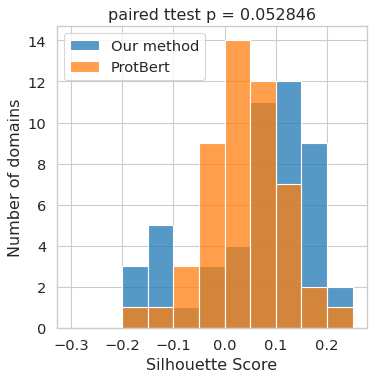

In [76]:
plt.figure(figsize=(5, 5), dpi=80)
sns.set(font_scale=1.2,style='whitegrid')
sns.histplot(silscores,bins=np.arange(-0.3,0.3,0.05),color=sns.color_palette('tab10')[0],label='Our method')
sns.histplot(protscores,bins=np.arange(-0.3,0.3,0.05),color=sns.color_palette('tab10')[1],label='ProtBert')
# plt.axvline(0,linestyle='--',linewidth=5,c='black')
plt.xlabel('Silhouette Score')
plt.ylabel('Number of domains')
plt.title(f'paired ttest p = {tp:4f}')
plt.legend()
plt.show()

In [84]:
i = 50
domain_silhouette_df = pd.DataFrame({
    'Domain': np.concatenate([domsrted.index[:i],domsrted.index[:i]]),
    'Silhouette Score': np.concatenate([silscores[:i],protscores[:i]]),
    'Embedding Method': ['Our Method']*i + ['ProtBert']*i,
})

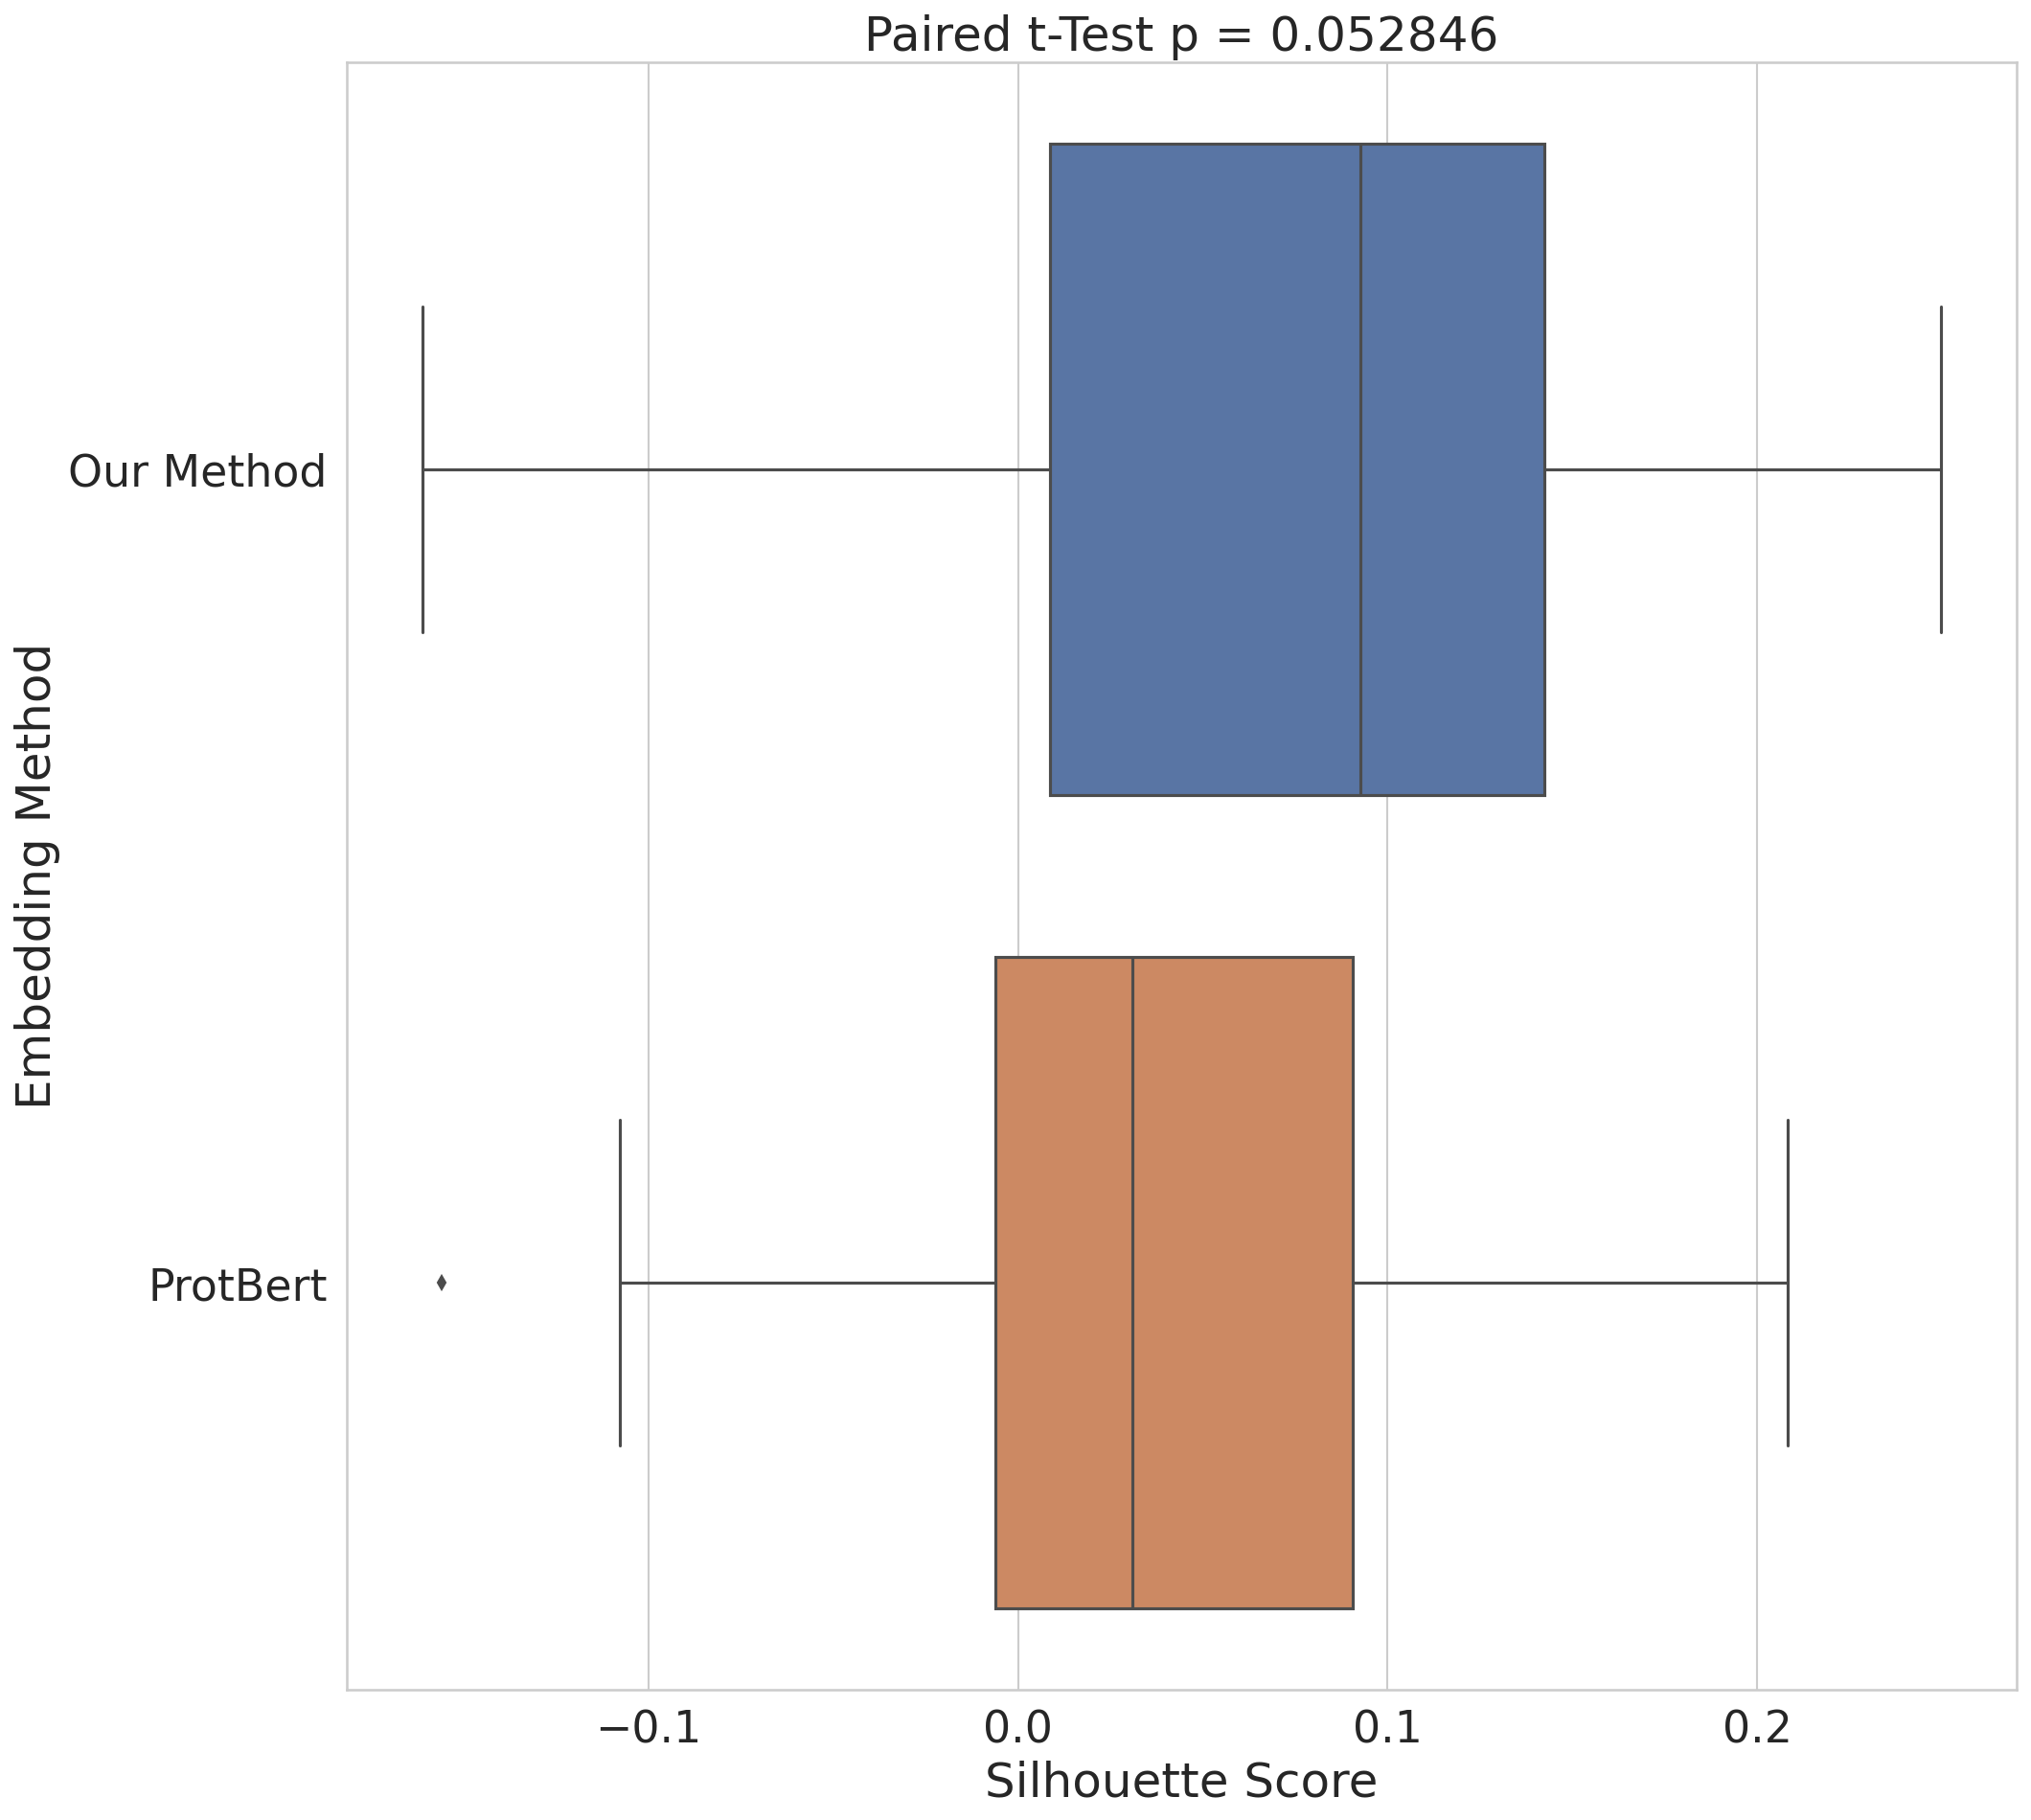

In [86]:
sns.set(style='whitegrid',font_scale=2)
plt.figure(figsize=(15, 15), dpi=150)

sns.boxplot(data=domain_silhouette_df,x='Silhouette Score',y='Embedding Method')
# plt.ylabel('Silhouette Score')
# plt.xlabel('Embedding Method')
plt.title(f'Paired t-Test p = {tp:4f}')
plt.savefig(f'../img/surfaceome_pfam_silhouettes_boxplot.svg',bbox_inches='tight')
plt.show()

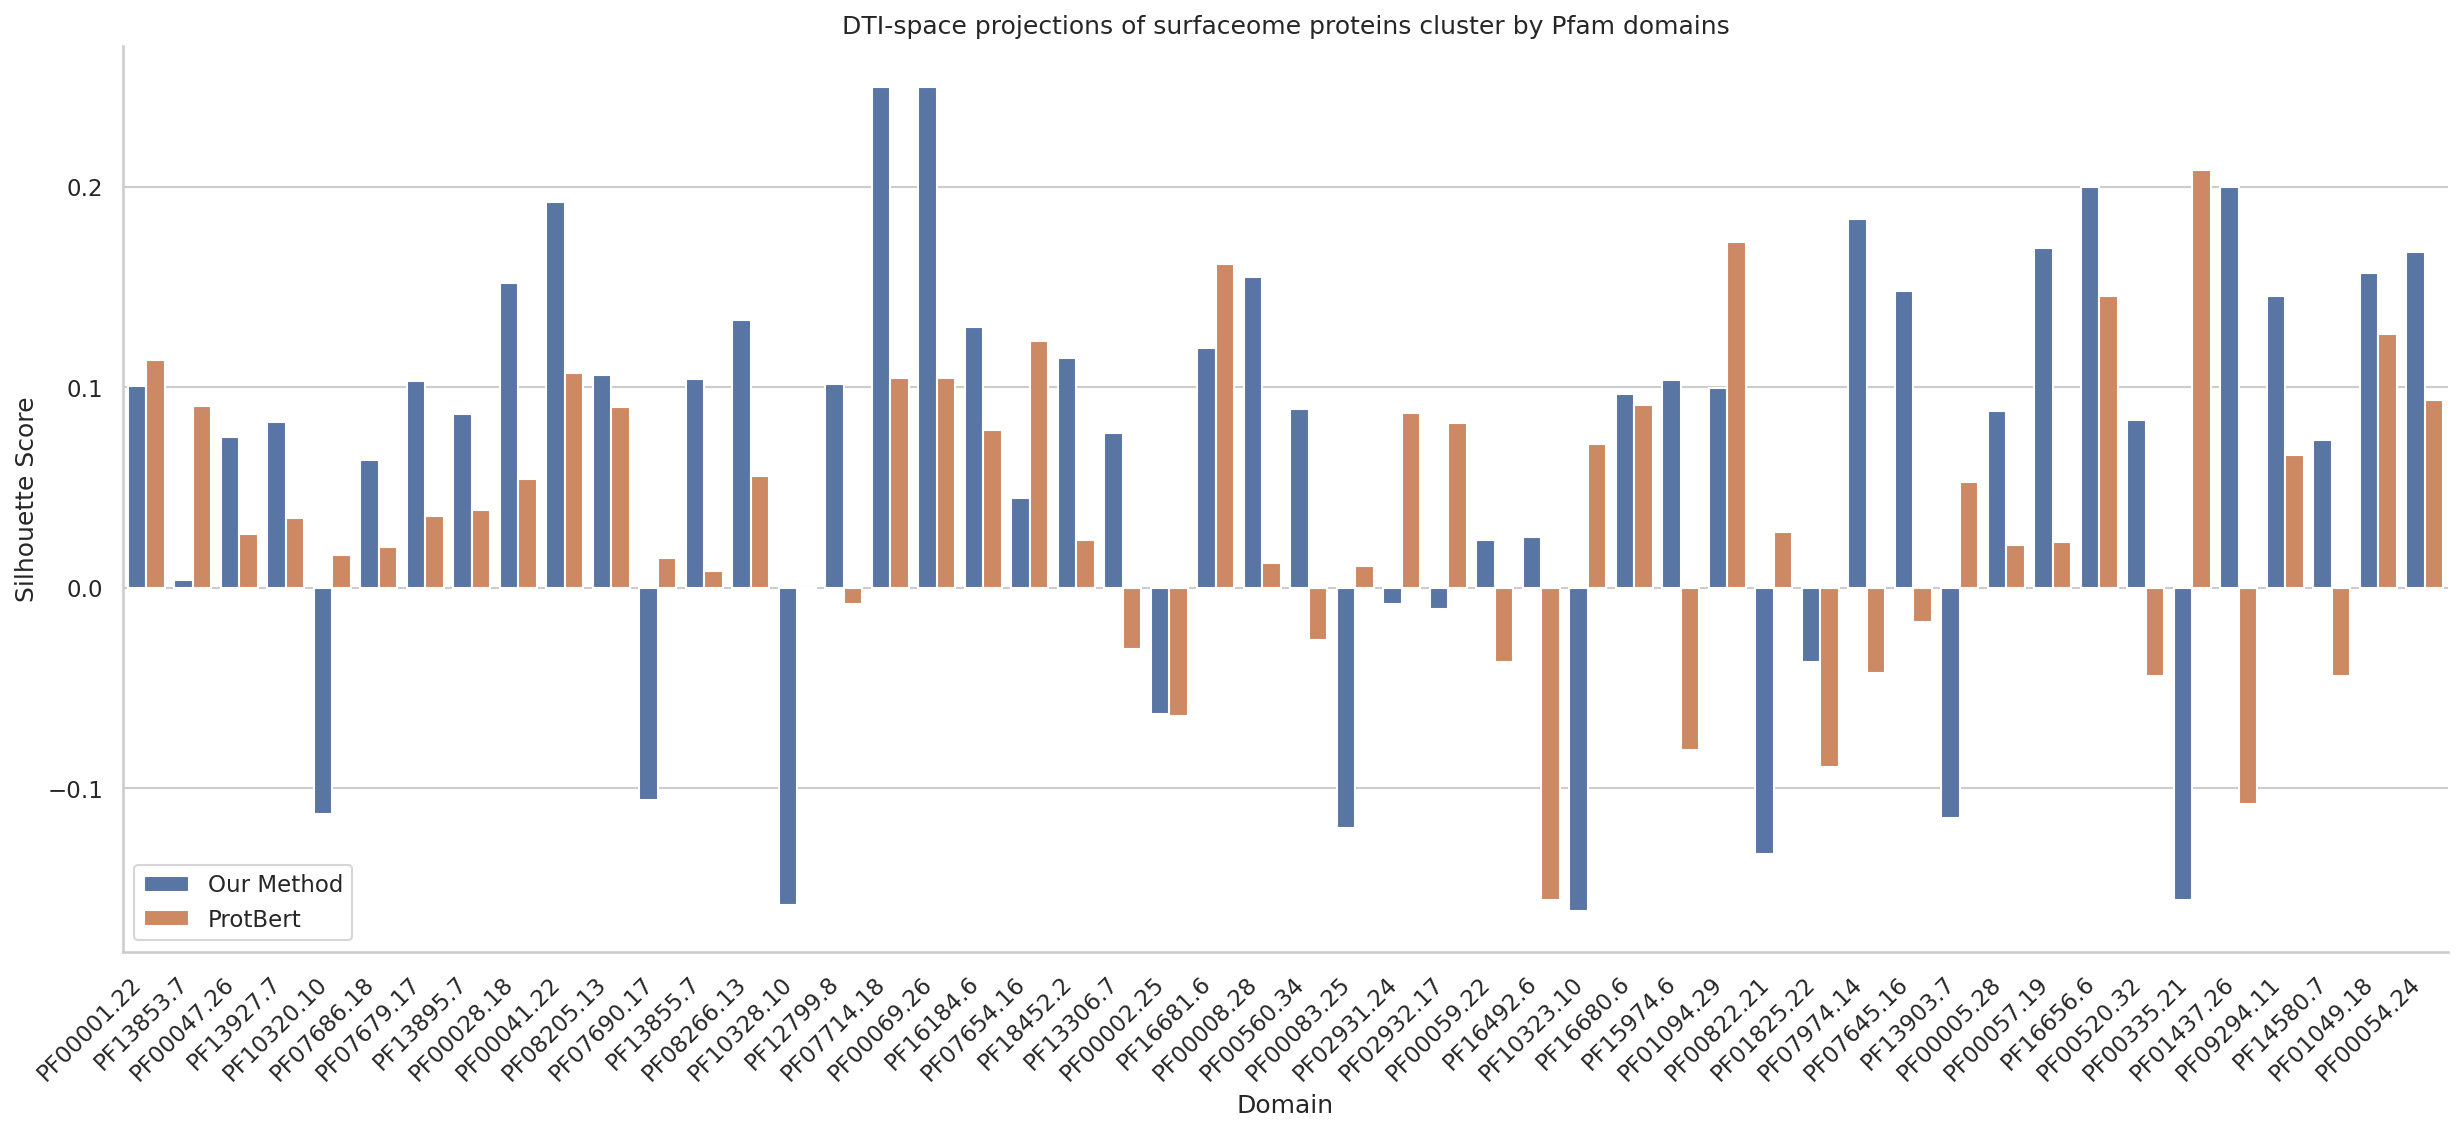

In [92]:
plt.figure(figsize=(20, 8), dpi=150)
sns.set(font_scale=1,style='whitegrid')

sns.barplot(data=domain_silhouette_df,x='Domain',y='Silhouette Score',hue='Embedding Method')
# plt.xlabel('Pfam domain')
# plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.title('DTI-space projections of surfaceome proteins cluster by Pfam domains')
plt.legend(loc='lower left')
sns.despine()
plt.savefig(f'../img/surfaceome_pfam_silhouettes_barplot.svg',bbox_inches='tight')
plt.show()

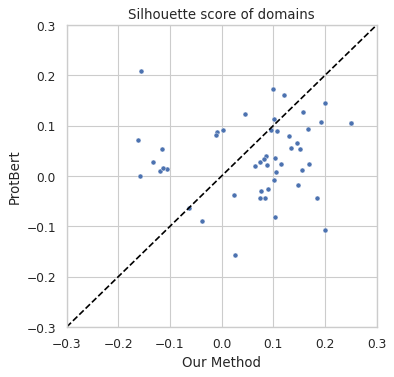

In [61]:
plt.figure(figsize=(5, 5), dpi=80)
sns.set(font_scale=1,style='whitegrid')

plt.plot([-0.3,0.3],[-0.3,0.3],color='black',linestyle='--')
sns.scatterplot(data=domain_silhouette_df.pivot('x','hue','y'),
                x='Our Method',
                y='ProtBert',
                s=20,
               )
plt.xlim(-0.3,0.3)
plt.ylim(-0.3,0.3)
plt.title('Silhouette score of domains')
plt.show()

---

## Classify Unclassified Targets

In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

In [96]:
class_names = ['Transporters','Miscellaneous','Receptors','Enzymes']

In [ ]:
# unk_names = ['Unclassified',
#  'Unknown_function;CSMD',
#  'Unknown_function;IG_Unknown_function',
#  'Unknown_function;ITM2',
#  'Unknown_function;LHFP',
#  'Unknown_function;LRRC37',
#  'Unknown_function;MS4A',
#  'Unknown_function;RNFT',
#  'Unknown_function;TM9SF',
#  'Unknown_function;TMEM132',
#  'Unknown_function;TMEM16',
#  'Unknown_function;TMEM30',
#  'Unknown_function;TMEM63',
#  'Unknown_function;TetraspaninL6']
# class_names = [i for i in set(almen_minor) if (i not in unk_names)][1:]

In [120]:
classified_targets = [pn for (pn,ac) in zip(prot_names, almen_class) if ac in class_names]
classified_labels = [ac for ac in almen_class if ac in class_names]
classified_projections = np.stack([pj for (pj,ac) in zip(prot_projections, almen_class) if ac in class_names])
classified_protbert = np.stack([pj for (pj,ac) in zip(protbert_np, almen_class) if ac in class_names])

unclassified_targets = [pn for (pn,ac) in zip(prot_names, almen_class) if ac not in class_names]
unclassified_projections = np.stack([pj for (pj,ac) in zip(prot_projections, almen_class) if ac not in class_names])
unclassified_protbert = np.stack([pj for (pj,ac) in zip(protbert_np, almen_class) if ac not in class_names])

In [98]:
len(classified_targets), len(unclassified_targets)

(2128, 588)

In [99]:
# classified_targets = [pn for (pn,ac) in zip(prot_names, almen_minor) if ac in class_names]
# classified_labels = [ac for ac in almen_minor if ac in class_names]
# classified_projections = np.stack([pj for (pj,ac) in zip(prot_projections, almen_minor) if ac in class_names])

# unclassified_targets = [pn for (pn,ac) in zip(prot_names, almen_minor) if ac not in class_names]
# unclassified_projections = np.stack([pj for (pj,ac) in zip(prot_projections, almen_minor) if ac not in class_names])

In [121]:
accs = []
acc_pb = []
aris = []
ari_pb = []

for k in np.arange(1,51):
    knn_cv = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    cv_score = cross_validate(knn_cv, 
                   X = classified_projections, 
                   y = classified_labels, 
                   scoring = ('accuracy','balanced_accuracy','adjusted_rand_score')
                  )
    cv_pb = cross_validate(knn_cv, 
                   X = classified_protbert, 
                   y = classified_labels, 
                   scoring = ('accuracy','balanced_accuracy','adjusted_rand_score')
                  )
    accs.append(cv_score['test_accuracy'].mean())
    acc_pb.append(cv_pb['test_accuracy'].mean())
    aris.append(cv_score['test_adjusted_rand_score'].mean())
    ari_pb.append(cv_pb['test_adjusted_rand_score'].mean())
    # print(k, cv_score['test_accuracy'].mean(), cv_score['test_adjusted_rand_score'].mean())

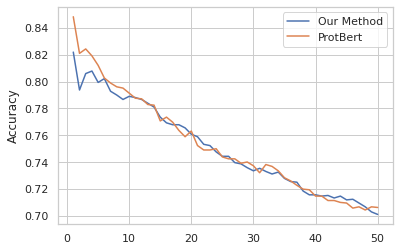

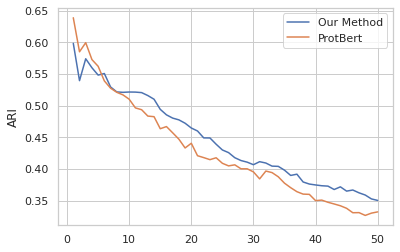

In [123]:
plt.plot(np.arange(1,51), accs, label='Our Method')
plt.plot(np.arange(1,51), acc_pb, label='ProtBert')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

plt.plot(np.arange(1,51), aris, label='Our Method')
plt.plot(np.arange(1,51), ari_pb, label='ProtBert')
plt.legend()
plt.ylabel('ARI')
plt.show()

In [102]:
pd.DataFrame(predictions, unclassified_targets).head(50)

,0
A0FGR9,Receptors
A2RRL7,Miscellaneous
A2VDJ0,Receptors
A6NC51,Receptors
A6ND01,Receptors
A6NDP7,Receptors
A6NDV4,Transporters
A6NF34,Miscellaneous
A6NFA1,Enzymes
A6NFX1,Transporters


In [110]:
known_or_not = []
new_ac = []
new_sizes = []
for ac, pp in zip(almen_class, prot_projections):
    if ac not in class_names:
        new_ac.append(knn_class.predict(pp.reshape(1, -1))[0])
        known_or_not.append("Unclassified")
        new_sizes.append(100)
    else:
        new_ac.append(ac)
        known_or_not.append(ac)
        new_sizes.append(20)

In [111]:
tab10_blue = sns.color_palette('tab10')[0]
tab10_red = sns.color_palette('tab10')[3]
tab10_green = sns.color_palette('tab10')[2]
tab10_grey = sns.color_palette('tab10')[7]
light_grey = (0.8,0.8,0.8)
palette = {"Transporters": tab10_blue, "Unclassified": light_grey, "Miscellaneous": tab10_grey, "Receptors": tab10_red, "Enzymes": tab10_green}

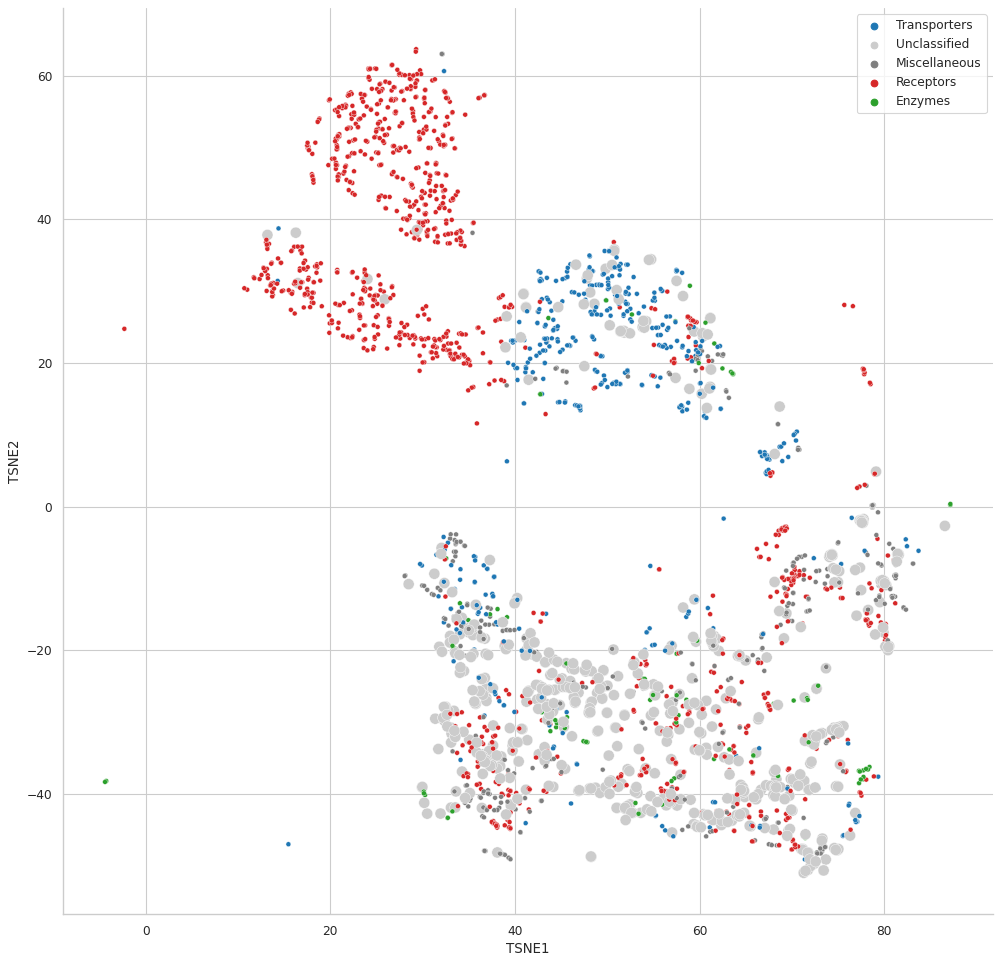

In [112]:
sns.set(style='whitegrid')
style = ['Molecule'] * mol_projections.shape[0]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(
                x=embed_tsne[:prot_projections.shape[0],0],
                y=embed_tsne[:prot_projections.shape[0],1],
                hue=known_or_not,
                s=new_sizes,
                alpha=1,
                palette=palette,
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
sns.despine()
plt.show()

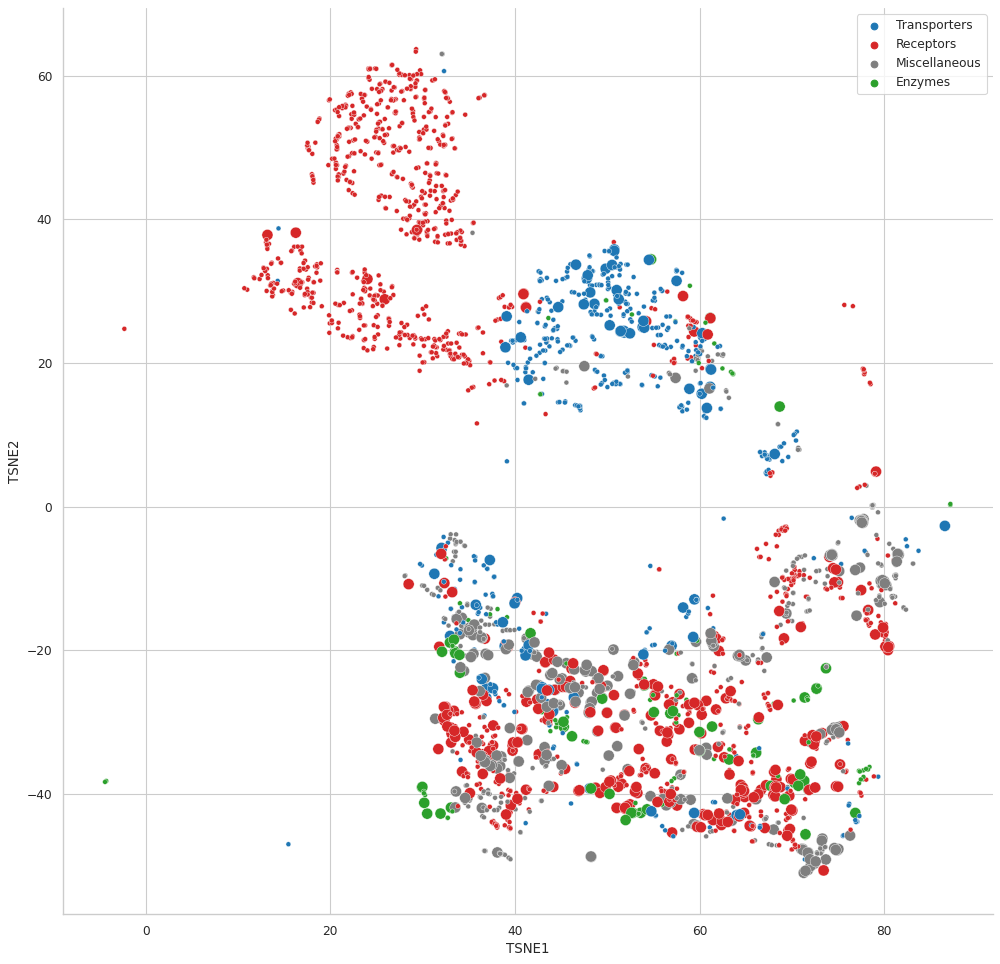

In [113]:
sns.set(style='whitegrid')
style = ['Molecule'] * mol_projections.shape[0]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(
                x=embed_tsne[:prot_projections.shape[0],0],
                y=embed_tsne[:prot_projections.shape[0],1],
                hue=new_ac,
                s=new_sizes,
                alpha=1,
                palette=palette,
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
sns.despine()
plt.show()

---
# Pairwise scores

In [ ]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine
cosine_sim = CosineSimilarity(dim=0)

pairwise = np.zeros((len(prot_names),len(mol_names)))
predictions = []
for i, (p_name, p_proj) in tqdm(enumerate(zip(prot_names,prot_projections)),total=len(prot_names)):
        p_proj_torch = torch.from_numpy(p_proj)
        for j, (m_name, m_proj) in enumerate(zip(mol_names,mol_projections)):
            with torch.set_grad_enabled(False):
                affin = cosine_sim(p_proj_torch,torch.from_numpy(m_proj)).numpy()
                predictions.append((p_name, m_name, affin))
                pairwise[i,j] = affin

In [ ]:
pred_df = pd.DataFrame(predictions,columns=['Target','Molecule','CosineSim'])
pred_df.head()

In [ ]:
pred_df.shape

In [ ]:
pred_df.to_csv('../nbdata/drugbank_x_surfaceome_classification_2022-07-07.csv',sep=',',header=True,index=False)

In [ ]:
mol_projections[:10]

In [ ]:
mol_names[:10]